# COVID-19 Cases And Deaths Forecast Using Facebook Prophet
## DS 440 

## COVID-19 Cases Prediction for United States

In [2]:
# Import packages
import numpy as np
import pystan
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import datetime
from pandas import to_datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in dataset
df = pd.read_csv('covid.csv')

In [4]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2/24/2020,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2/25/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2/26/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2/27/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2/28/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [5]:
# Quantify rows and columns
df.shape

(155261, 67)

In [6]:
# List of columns
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# Create different simple models for predicting number of deaths for one region (I'm choosing USA)

In [7]:
# Subset data for only US data
df_us = df.loc[df['location'] == 'United States']

In [8]:
df_us.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
146768,USA,North America,United States,1/22/2020,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146769,USA,North America,United States,1/23/2020,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146770,USA,North America,United States,1/24/2020,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146771,USA,North America,United States,1/25/2020,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146772,USA,North America,United States,1/26/2020,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8925.0,-3.59,-2.63,-26.808639


In [9]:
# Subset for only the dates and total_cases columns (time series data only works with 
# one variable from what I can find)

df_us_cases = df_us[['date', 'total_cases']]
df_us_cases.head()

,date,total_cases
146768,1/22/2020,1.0
146769,1/23/2020,1.0
146770,1/24/2020,2.0
146771,1/25/2020,2.0
146772,1/26/2020,5.0


In [10]:
# Check for null values
print(df_us_cases['total_cases'].isnull().sum())
print(df_us_cases['total_cases'].isna().sum())

0
0


In [11]:
# Rename columns for Prophet model
df_us_cases.columns = ['ds', 'y']
df_us_cases.head()

,ds,y
146768,1/22/2020,1.0
146769,1/23/2020,1.0
146770,1/24/2020,2.0
146771,1/25/2020,2.0
146772,1/26/2020,5.0


In [12]:
# Need to set the date col to be a df index and format the date column to a date type
df_us_cases['ds'] = pd.to_datetime(df_us_cases['ds'])
#df_us.index = pd.to_datetime(df_us['ds'], format='%m-%d-%Y')
df_us_cases.head()

,ds,y
146768,2020-01-22,1.0
146769,2020-01-23,1.0
146770,2020-01-24,2.0
146771,2020-01-25,2.0
146772,2020-01-26,5.0


In [16]:
df_us_cases.dtypes
df_us_cases.reset_index(drop=True, inplace=True)

In [17]:
model_daily = Prophet(daily_seasonality=True)
model_weekly = Prophet(weekly_seasonality=True)
model_yearly = Prophet(yearly_seasonality=True)

In [19]:
model_daily.fit(df_us_cases)
model_weekly.fit(df_us_cases)
model_yearly.fit(df_us_cases)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
future_daily = model_daily.make_future_dataframe(periods=365)
future_weekly = model_weekly.make_future_dataframe(periods=365)
future_yearly = model_yearly.make_future_dataframe(periods=365)

In [22]:
pred_daily=model_daily.predict(future_daily)
pred_weekly=model_weekly.predict(future_weekly)
pred_yearly=model_yearly.predict(future_yearly)

In [23]:
pred_daily[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()
pred_weekly[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()
pred_yearly[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-801437.796538,-1.027918e+06,-592638.378357
1,2020-01-23,-592037.402008,-8.148453e+05,-388619.803117
2,2020-01-24,-389354.283976,-6.234716e+05,-175258.639753
3,2020-01-25,-249603.763071,-4.618522e+05,-26016.915287
4,2020-01-26,-138163.272195,-3.421107e+05,75276.424147


# Predictions using Daily Seasonality

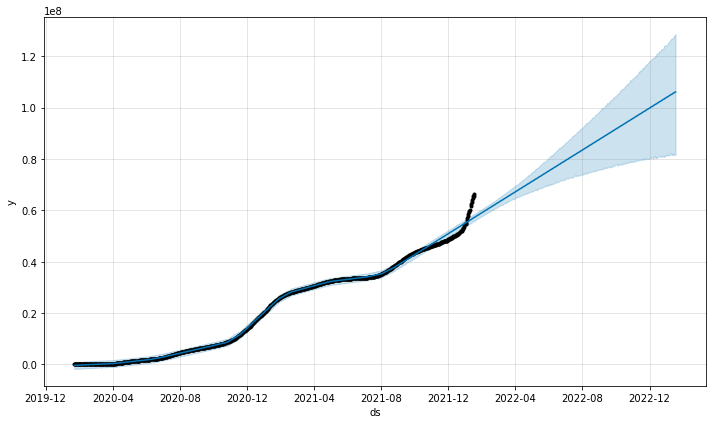

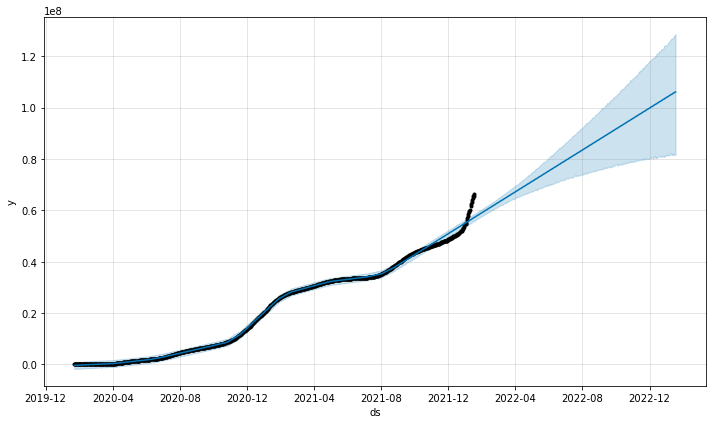

In [24]:
model_daily.plot(pred_daily)

# Predictions using Weekly Seasonality

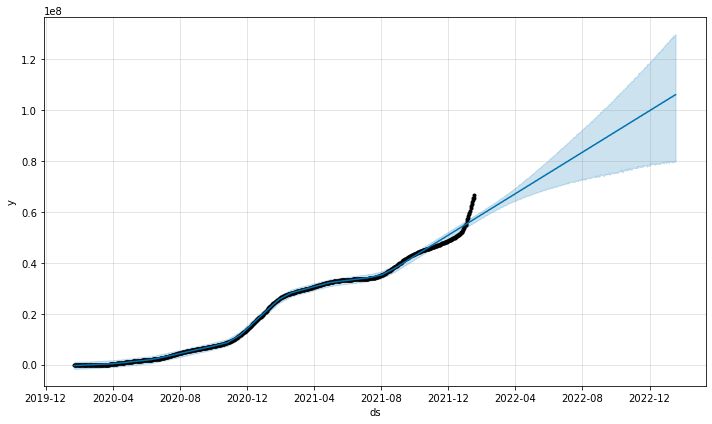

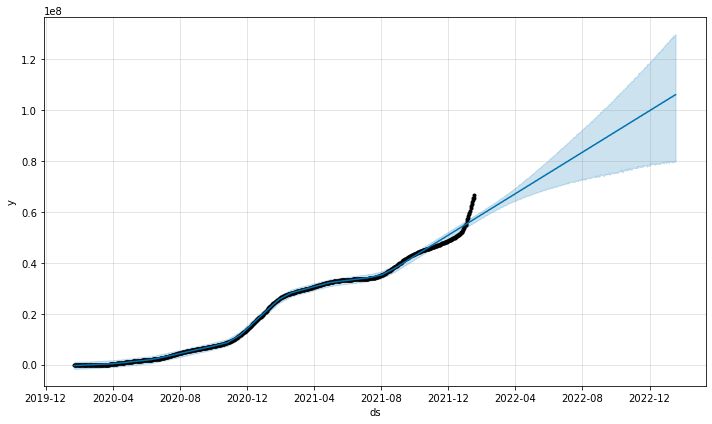

In [25]:
model_weekly.plot(pred_weekly)

# Predictions using Yearly Seasonality

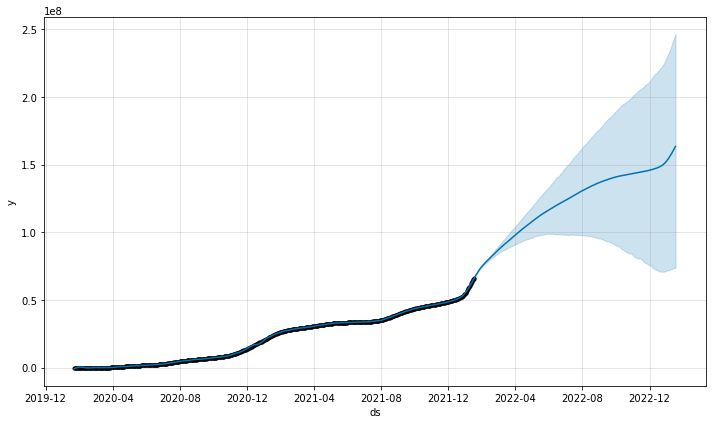

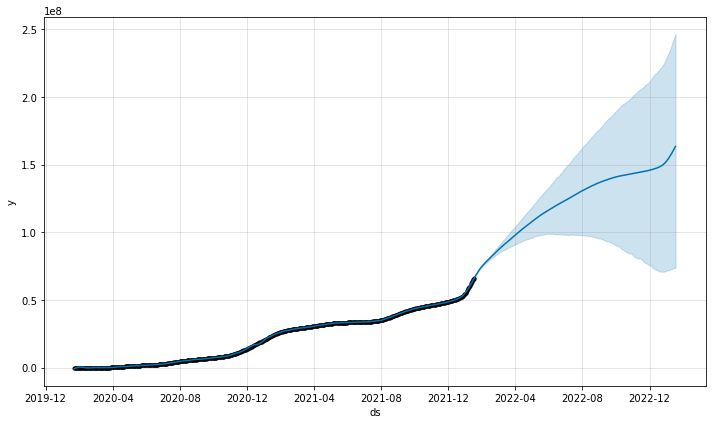

In [26]:
model_yearly.plot(pred_yearly)

## COVID-19 Cases Prediction for United States

In [16]:
# Subset data for only US data
df_us = df.loc[df['location'] == 'United States']

In [25]:
# Subset for only the dates and total_deaths columns (time series data only works with 
# one variable from what I can find)

df_us_deaths = df_us[['date', 'total_deaths']]
df_us_deaths.head()

,date,total_deaths
146768,1/22/2020,NaN
146769,1/23/2020,NaN
146770,1/24/2020,NaN
146771,1/25/2020,NaN
146772,1/26/2020,NaN


In [28]:
# Check for null values
print(df_us_deaths['total_deaths'].isnull().sum())
print(df_us_deaths['total_deaths'].isna().sum())

38
38


In [29]:
df_us_deaths = df_us_deaths.dropna()

In [30]:
print(df_us_deaths['total_deaths'].isnull().sum())
print(df_us_deaths['total_deaths'].isna().sum())

0
0


In [31]:
# Rename columns for Prophet model
df_us_deaths.columns = ['ds', 'y']
df_us_deaths.head()

,ds,y
146806,2/29/2020,1.0
146807,3/1/2020,1.0
146808,3/2/2020,6.0
146809,3/3/2020,7.0
146810,3/4/2020,11.0


In [32]:
# Need to set the date col to be a df index and format the date column to a date type
df_us_deaths['ds'] = pd.to_datetime(df_us_deaths['ds'])
#df_us.index = pd.to_datetime(df_us['ds'], format='%m-%d-%Y')
df_us_deaths.head()

,ds,y
146806,2020-02-29,1.0
146807,2020-03-01,1.0
146808,2020-03-02,6.0
146809,2020-03-03,7.0
146810,2020-03-04,11.0


In [34]:
df_us_deaths.reset_index(drop=True, inplace=True)
df_us_deaths.head()

,ds,y
0,2020-02-29,1.0
1,2020-03-01,1.0
2,2020-03-02,6.0
3,2020-03-03,7.0
4,2020-03-04,11.0


In [35]:
model_daily = Prophet(daily_seasonality=True)
model_weekly = Prophet(weekly_seasonality=True)
model_yearly = Prophet(yearly_seasonality=True)

In [36]:
model_daily.fit(df_us_deaths)
model_weekly.fit(df_us_deaths)
model_yearly.fit(df_us_deaths)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
future_daily = model_daily.make_future_dataframe(periods=365)
future_weekly = model_weekly.make_future_dataframe(periods=365)
future_yearly = model_yearly.make_future_dataframe(periods=365)

In [38]:
pred_daily=model_daily.predict(future_daily)
pred_weekly=model_weekly.predict(future_weekly)
pred_yearly=model_yearly.predict(future_yearly)

In [39]:
pred_daily[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()
pred_weekly[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()
pred_yearly[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-02-29,-929.825589,-1866.581272,-56.513595
1,2020-03-01,-1165.052480,-2103.061215,-159.864330
2,2020-03-02,-1098.151063,-2035.984583,-207.097665
3,2020-03-03,-535.966166,-1408.574687,321.418824
4,2020-03-04,191.738682,-679.660003,1110.244559


# Predictions using Daily Seasonality

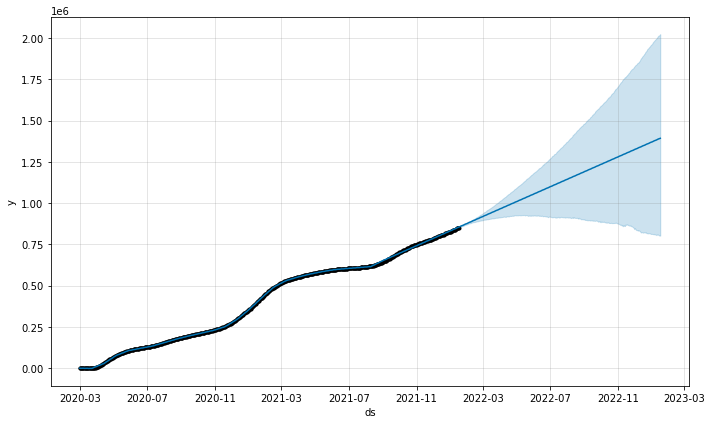

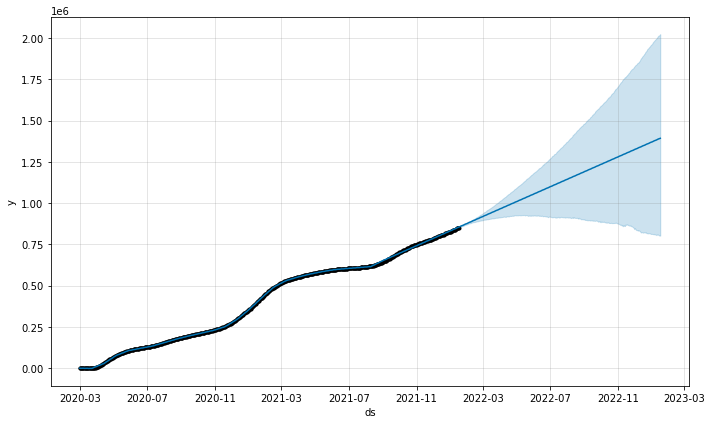

In [40]:
model_daily.plot(pred_daily)

# Predictions using Weekly Seasonality

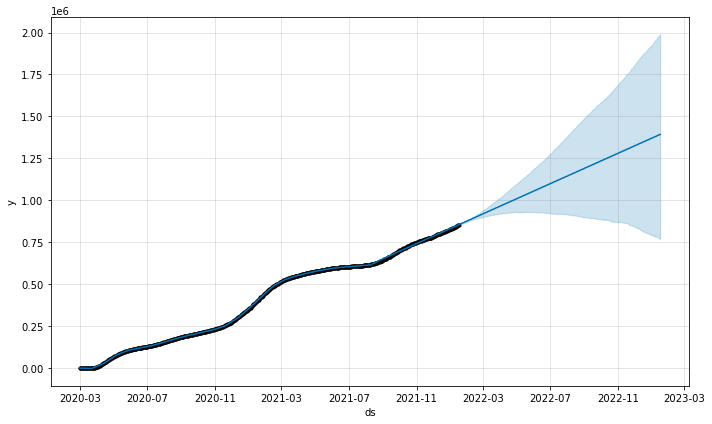

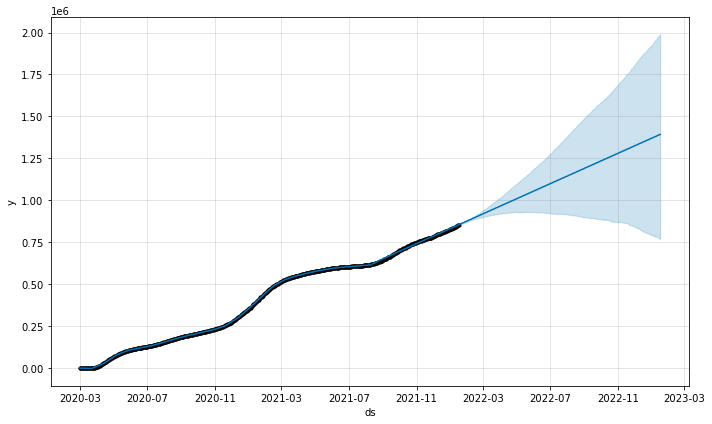

In [41]:
model_weekly.plot(pred_weekly)

# Predictions using Yearly Seasonality

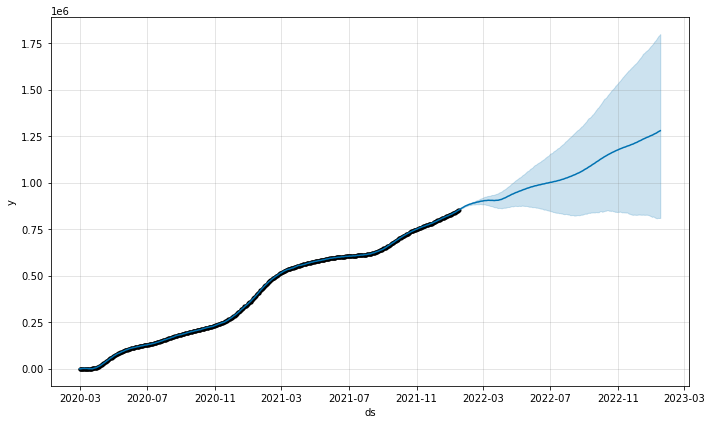

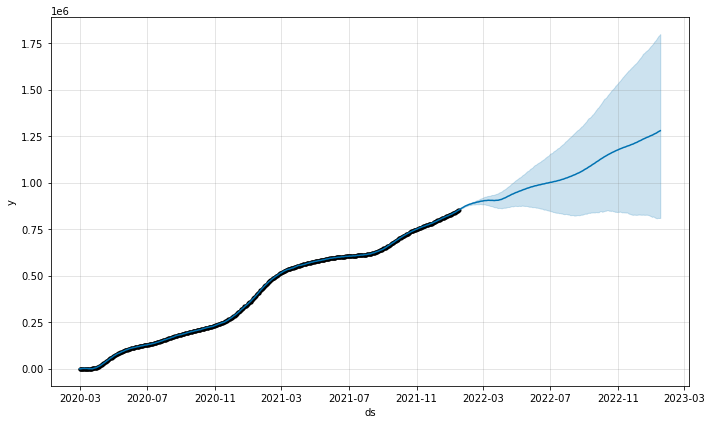

In [42]:
model_yearly.plot(pred_yearly)